# Определение возраста покупателей

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.
Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.


**План работы:** 
* Провести исследовательский анализ набора фотографий.
* Подготовить данные к обучению.
* Обучить нейронную сеть и рассчитайте её качество.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
#Смотрим на размер выборки.
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

features, target = next(train_gen_flow)

print('Размер выборки:', labels.shape)

Found 7591 validated image filenames.
Размер выборки: (7591, 2)


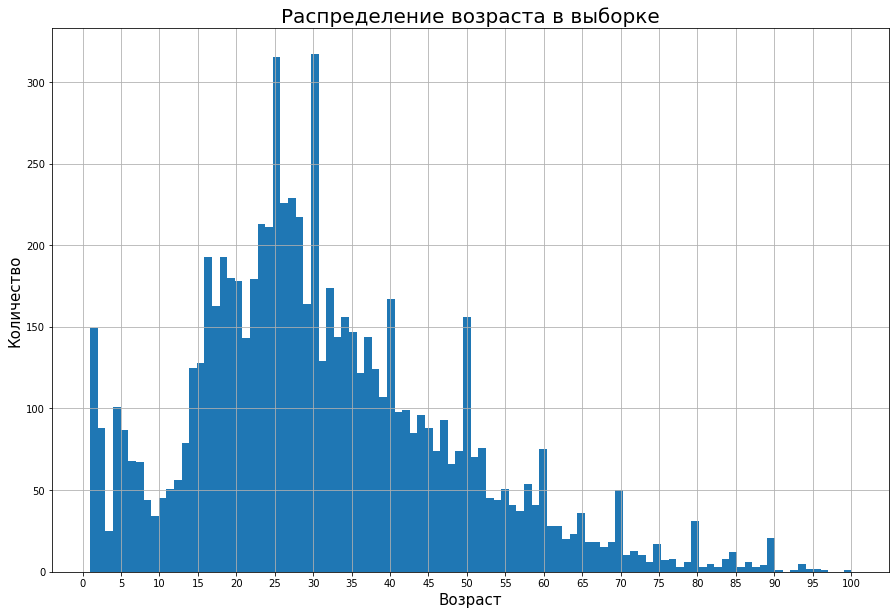

In [3]:
#Строим график распределения возраста в выборке.
plt.figure(figsize=(15, 10))
plt.xlabel('Возраст', fontsize=15)
plt.ylabel('Количество', fontsize=15)
plt.title('Распределение возраста в выборке', fontsize=20)
plt.xticks(np.arange(0, 101, step=5))
labels['real_age'].hist(bins=100);

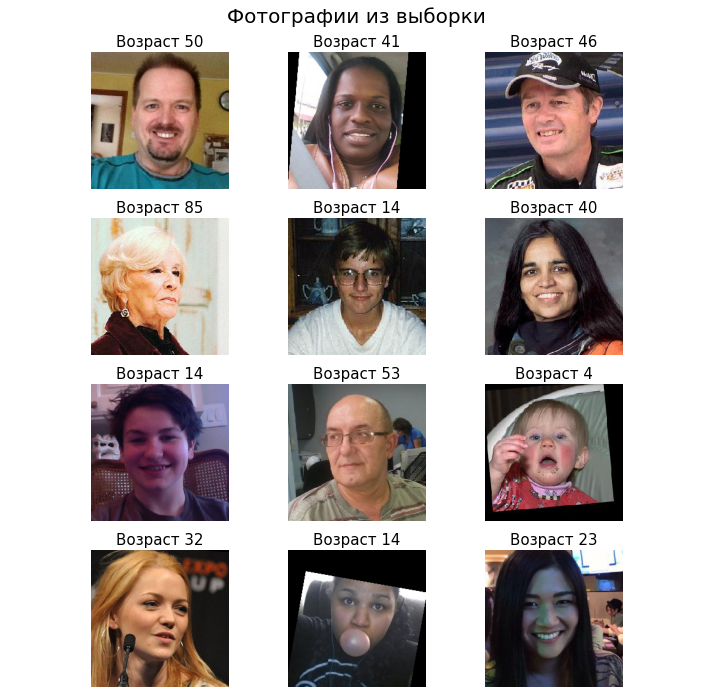

In [4]:
#Печатаем на экране 10–15 фотографий и смотрим, как устроен датасет.
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Фотографии из выборки', loc = "center", pad = 30, fontsize=20)

for i in range(12):
        fig.add_subplot(4, 3, i+1)
        plt.imshow(features[i])
        plt.axis('off')
        plt.title("Возраст %s" %target[i], fontsize=15)
        plt.tight_layout()
       

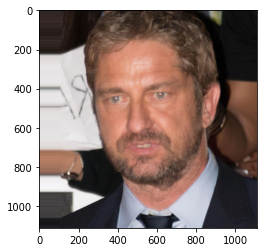

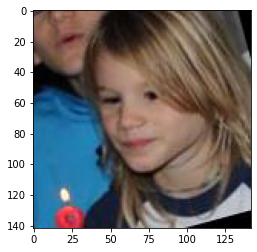

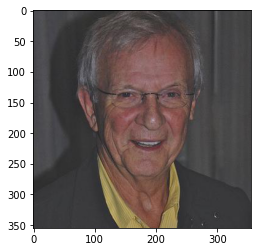

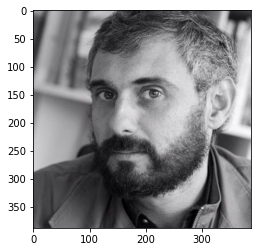

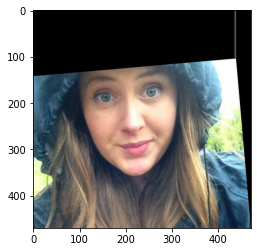

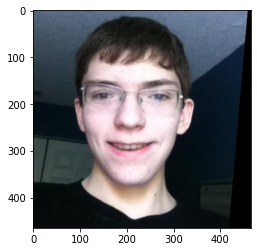

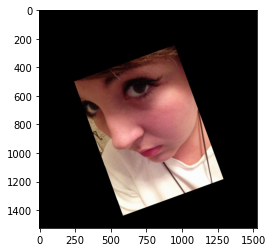

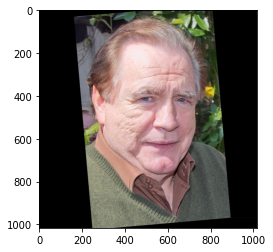

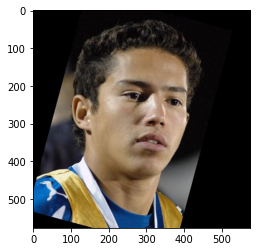

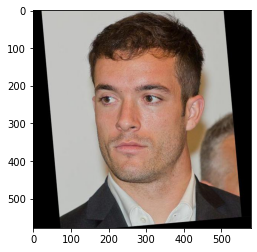

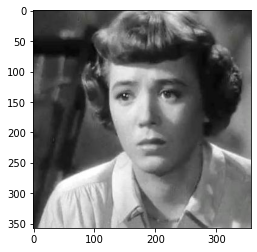

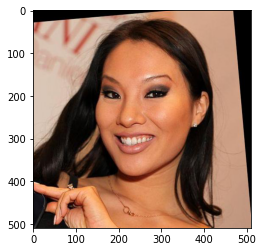

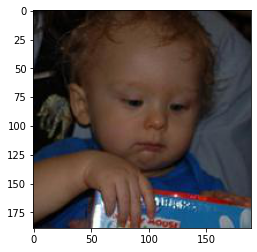

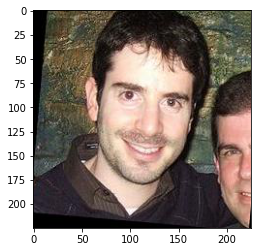

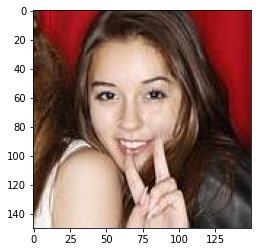

In [5]:
# вывод случайных изображений
photos = os.listdir('/datasets/faces/final_files/')
for i in random.sample(photos, k=15):

    image = Image.open('/datasets/faces/final_files/' + i)
    plt.imshow(np.array(image))
    plt.show()

Исходя из исследования, можно сделать следующие выводы:
* Количества изображений достаточно, чтобы использовать ResNet50 и не "замораживать" слои;
* Возраст преимущественно распределен в интервале от 20 до 40 лет, имеются пики в "круглых" датах, вероятно, вследствие округления возраста;
* Фотографии преимущественно цветные, но есть и черно-белые, ориентация изображений портретная, основной объем на изображении занимает лицо, положения лиц выровнены;
* Есть лица в очках, а так же повернутые немного в сторону. Это должно помочь лучше обучить модель, т.к. не всегда люди перед кассой будут ровно смотреть в камеру.
* На изображениях лица людей, для увеличения объема данных можно использовать horizontal_flip;
* Т.к. нам нужно предсказать возраст по фото, это задача регрессии и допустимые функции потерь: mean_squared_error и  mean_absolute_error. Будем использовать функцию потреть MSE, а метрику - MAE. 

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
 
    return model

 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch == None:
        steps_per_epoch = len(train_data)
    if validation_steps == None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model
```

```


Train for 356 steps, validate for 119 steps
Epoch 1/10
2022-08-23 12:41:39.729385: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-23 12:41:40.038076: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 49s - loss: 198.7329 - mean_absolute_error: 10.2721 - val_loss: 648.8781 - val_mean_absolute_error: 20.2831
Epoch 2/10
356/356 - 39s - loss: 82.6011 - mean_absolute_error: 6.9552 - val_loss: 176.4693 - val_mean_absolute_error: 10.2596
Epoch 3/10
356/356 - 41s - loss: 56.3471 - mean_absolute_error: 5.7518 - val_loss: 102.3092 - val_mean_absolute_error: 7.5150
Epoch 4/10
356/356 - 41s - loss: 41.7766 - mean_absolute_error: 4.9379 - val_loss: 75.3803 - val_mean_absolute_error: 6.5076
Epoch 5/10
356/356 - 56s - loss: 33.8962 - mean_absolute_error: 4.4228 - val_loss: 81.6192 - val_mean_absolute_error: 6.6349
Epoch 6/10
356/356 - 57s - loss: 25.9939 - mean_absolute_error: 3.9190 - val_loss: 74.7382 - val_mean_absolute_error: 6.2361
Epoch 7/10
356/356 - 49s - loss: 20.2493 - mean_absolute_error: 3.4421 - val_loss: 69.2555 - val_mean_absolute_error: 6.3017
Epoch 8/10
356/356 - 52s - loss: 17.0599 - mean_absolute_error: 3.1398 - val_loss: 68.0551 - val_mean_absolute_error: 6.1659
Epoch 9/10
356/356 - 54s - loss: 21.7065 - mean_absolute_error: 3.4851 - val_loss: 69.1188 - val_mean_absolute_error: 6.2945
Epoch 10/10
356/356 - 54s - loss: 17.9698 - mean_absolute_error: 3.2079 - val_loss: 65.3003 - val_mean_absolute_error: 6.0536
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 65.3003 - mean_absolute_error: 6.0536
Test MAE: 6.0536


```

## Анализ обученной модели

Для задачи использовалась модель ResNet50, предобученная на датасете ImageNet. В последнем слое 1 нейрон и активация ReLU. 
В качестве оптимизатора использовался алгоритм Adam со скоростью обучения 0.0001, количество эпох = 10. 

Результат на тестовой выборке 6,05 и находится в пределах допустимой нормы < 8. 

В проекте стояла задача определить возраст клиентов с помощью фотофиксации в прикассовой зоне для того, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.
По второму пункту можно рекомендовать кассирам проверять документы у клиентов, возраст которых модель определила как 25 и меньше.